# Implementing ResNet-18 Using Keras

Implement ResNet-18 using Keras

Codes below are taken from [Github](https://github.com/songrise/CNN_Keras)

## preprocess

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [2]:

# Adding TF Cifar10 Data ..
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()



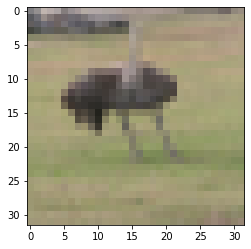

In [3]:
# Drawing sample . 
plt.imshow(X_train[42])

In [4]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

## Data Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

# Implement ResNet-18 model

In [8]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out



In [9]:
model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  74368     
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple          

In [10]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])



Epoch 1/50
156/156 [==============================] - 27s 139ms/step - loss: 1.9982 - accuracy: 0.3531 - val_loss: 2.2968 - val_accuracy: 0.2672
Epoch 2/50
156/156 [==============================] - 20s 130ms/step - loss: 1.2617 - accuracy: 0.5490 - val_loss: 1.4379 - val_accuracy: 0.4797
Epoch 3/50
156/156 [==============================] - 20s 129ms/step - loss: 1.0855 - accuracy: 0.6098 - val_loss: 1.1431 - val_accuracy: 0.5984
Epoch 4/50
156/156 [==============================] - 20s 130ms/step - loss: 0.9781 - accuracy: 0.6538 - val_loss: 1.0788 - val_accuracy: 0.6245
Epoch 5/50
156/156 [==============================] - 20s 130ms/step - loss: 0.8728 - accuracy: 0.6917 - val_loss: 0.9970 - val_accuracy: 0.6519
Epoch 6/50
156/156 [==============================] - 20s 131ms/step - loss: 0.8041 - accuracy: 0.7187 - val_loss: 1.0168 - val_accuracy: 0.6426
Epoch 7/50
156/156 [==============================] - 20s 129ms/step - loss: 0.7487 - accuracy: 0.7345 - val_loss: 1.0912 - val_ac

## train curve

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


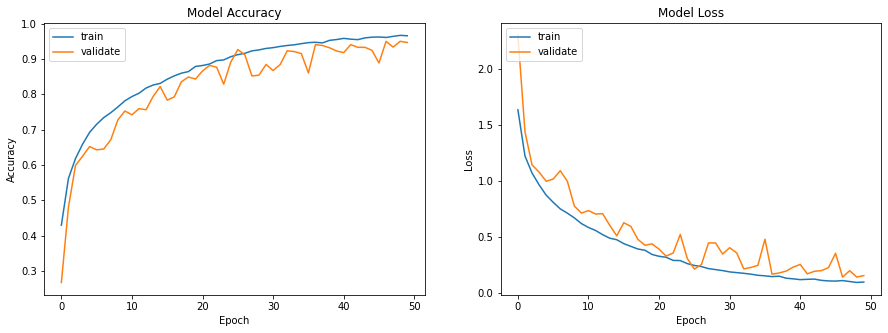

In [11]:

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)


##  Evaluation

In [12]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1564 - accuracy: 0.9466
Model Loss is 0.15642131865024567
Model Accuracy is 0.9466249942779541


In [13]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, Y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 2s 8ms/step - loss: 1.1289 - accuracy: 0.7561
Model Loss is 1.128940224647522
Model Accuracy is 0.7560999989509583


# Save Model

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# save model's weights
model.save_weights('drive/MyDrive/app/resnet_18.h5')

# Load Saved Model

In [17]:
# create model and load weights
model2 = ResNet18(10)
model2.build(input_shape = (None,32,32,3))
model2.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=["accuracy"])

# load weights
model2.load_weights('drive/MyDrive/app/resnet_18.h5')

In [18]:
ModelLoss, ModelAccuracy = model2.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 9s 7ms/step - loss: 0.1582 - accuracy: 0.9461
Model Loss is 0.15642131865024567
Model Accuracy is 0.9466249942779541


In [19]:
ModelLoss, ModelAccuracy = model2.evaluate(X_test, Y_test)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

313/313 [==============================] - 3s 8ms/step - loss: 1.1289 - accuracy: 0.7561
Model Loss is 1.128940224647522
Model Accuracy is 0.7560999989509583


# Prediction

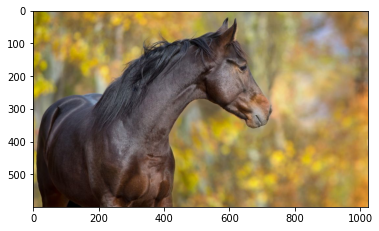

In [20]:
from PIL import Image

im = Image.open("drive/MyDrive/app/data/images/horse.jpg")
_ = plt.imshow(im)

In [21]:
def predict(classifier, image_path):
  # class label
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  image = Image.open(image_path)
  #plt.show(image)

  # resize image
  im = image.resize((32,32))
  
  # normalize the data.
  im = np.array(im).astype('float32') / 255.0
  im = np.expand_dims(im, axis=0)

  # close image
  image.close()

  # classify image
  pred = classifier.predict(im)
  index = np.argmax(pred, axis=1)[0]

  print(image_path.split('/')[-1], ':', labels[index], pred[0][index])

In [23]:
import glob

for img in glob.glob("drive/MyDrive/app/data/images/*.jpg"):
    predict(model2, img)

horse.jpg : truck 0.5794575
cat.jpg : dog 0.52896076
car.jpg : automobile 0.99995077
